In [21]:
from matplotlib.pyplot import figure, show
import matplotlib.pyplot as plt
import numpy as np
import numba

from osgeo import gdal

from scipy.interpolate import RectBivariateSpline


import time

In [22]:
from scipy.ndimage.filters import uniform_filter
from scipy.ndimage.measurements import variance

def lee_filter(img, size):
    """Speckle reduction filter from https://stackoverflow.com/questions/39785970/speckle-lee-filter-in-python"""
    
    img_mean = uniform_filter(img, (size, size))
    img_sqr_mean = uniform_filter(img**2, (size, size))
    img_variance = img_sqr_mean - img_mean**2

    overall_variance = variance(img)

    img_weights = img_variance / (img_variance + overall_variance)
    img_output = img_mean + img_weights * (img - img_mean)
    return img_output

/tmp/ipykernel_47127/1568718901.py:1: DeprecationWarning: Please use `uniform_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import uniform_filter
/tmp/ipykernel_47127/1568718901.py:2: DeprecationWarning: Please use `variance` from the `scipy.ndimage` namespace, the `scipy.ndimage.measurements` namespace is deprecated.
  from scipy.ndimage.measurements import variance


In [23]:
### Open rasters

ds = gdal.Open("/home/yadevries/sarpixeltracking/reference_slc/reference.slc", gdal.GA_ReadOnly)
reference_raster = ds.GetRasterBand(1).ReadAsArray()
ds = None

ds = gdal.Open("/home/yadevries/sarpixeltracking/coregisteredSlc/refined_coreg.slc", gdal.GA_ReadOnly)
secondary_coreg_raster = ds.GetRasterBand(1).ReadAsArray()
ds = None

### Flip and take amplitude of rasters

reference_raster_amp = np.flipud(np.abs(reference_raster))

secondary_coreg_raster_amp = np.flipud(np.abs(secondary_coreg_raster))



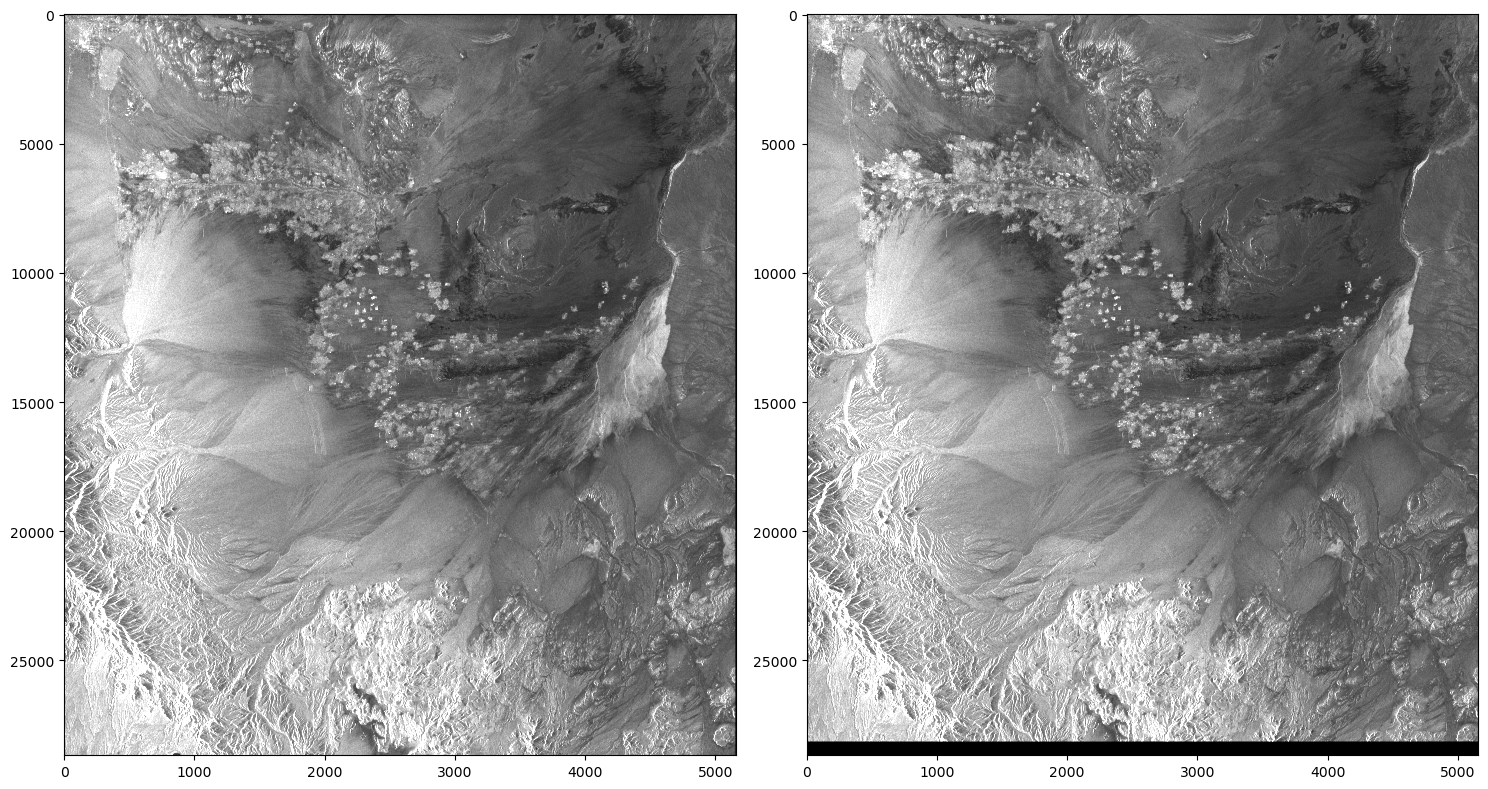

In [24]:
fig = plt.figure(figsize=(15, 8))

# display amplitude of the slc
fr1 = fig.add_subplot(1,2,1)

fr1.imshow(reference_raster_amp, vmin=None, vmax=4, cmap='gray', aspect='auto')

fr2 = fig.add_subplot(1,2,2)

fr2.imshow(secondary_coreg_raster_amp, vmin=None, vmax=4, cmap='gray', aspect='auto')

fig.tight_layout()

plt.show()

In [25]:
### slice rasters

reference_raster_amp_sliced = reference_raster_amp[0:10000, 10:1500]

secondary_coreg_raster_amp_sliced = secondary_coreg_raster_amp[0:10000, 10:1500]

### speckle reduce

reference_raster_amp_sliced_despeck = lee_filter(reference_raster_amp_sliced, 10)
secondary_coreg_raster_amp_sliced_despeck = lee_filter(secondary_coreg_raster_amp_sliced, 10)

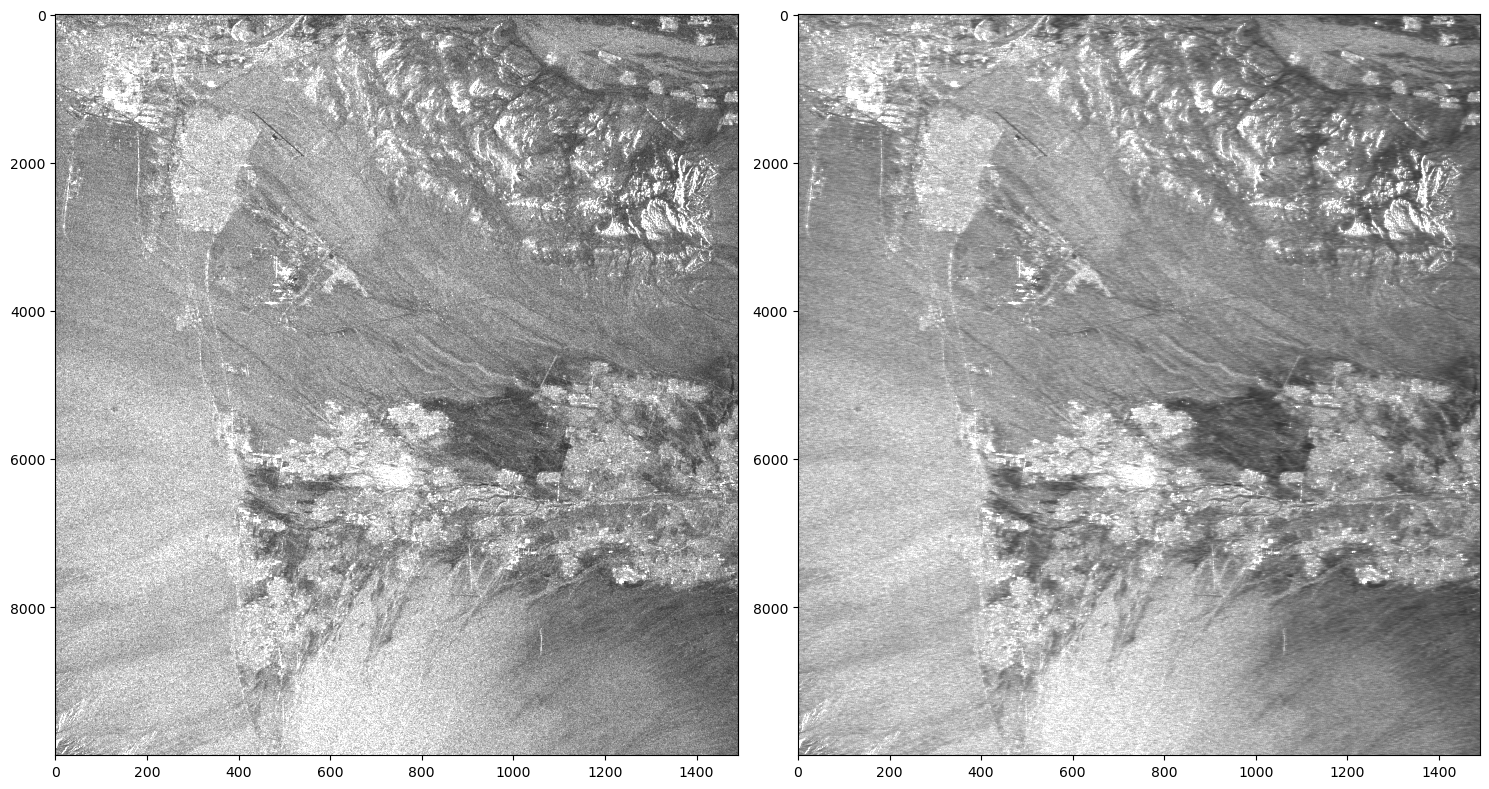

In [26]:
fig = plt.figure(figsize=(15, 8))

# display amplitude of the slc
fr1 = fig.add_subplot(1,2,1)

fr1.imshow(reference_raster_amp_sliced, vmin=None, vmax=4, cmap='gray', aspect='auto')

fr2 = fig.add_subplot(1,2,2)

fr2.imshow(reference_raster_amp_sliced_despeck, vmin=None, vmax=4, cmap='gray', aspect='auto')

fig.tight_layout()

plt.show()

In [27]:
### constants

SearchX = 127
SearchY = 127

WindowX = 65
WindowY = 65

skipX = 64
skipY = 128

lenY, lenX = np.shape(reference_raster_amp_sliced)

print(lenY, lenX)
### First attempt at looping over images

print(int(np.floor(lenX/skipX)))

xs = []
ys = []
for i in range(1, int(np.floor(lenX/skipX))):
    for j in range(1, int(np.floor(lenY/skipY))):        
        xs.append(i * skipX)
        ys.append(j * skipY)

print(len(xs))
print(len(ys))

10000 1490
23
1694
1694


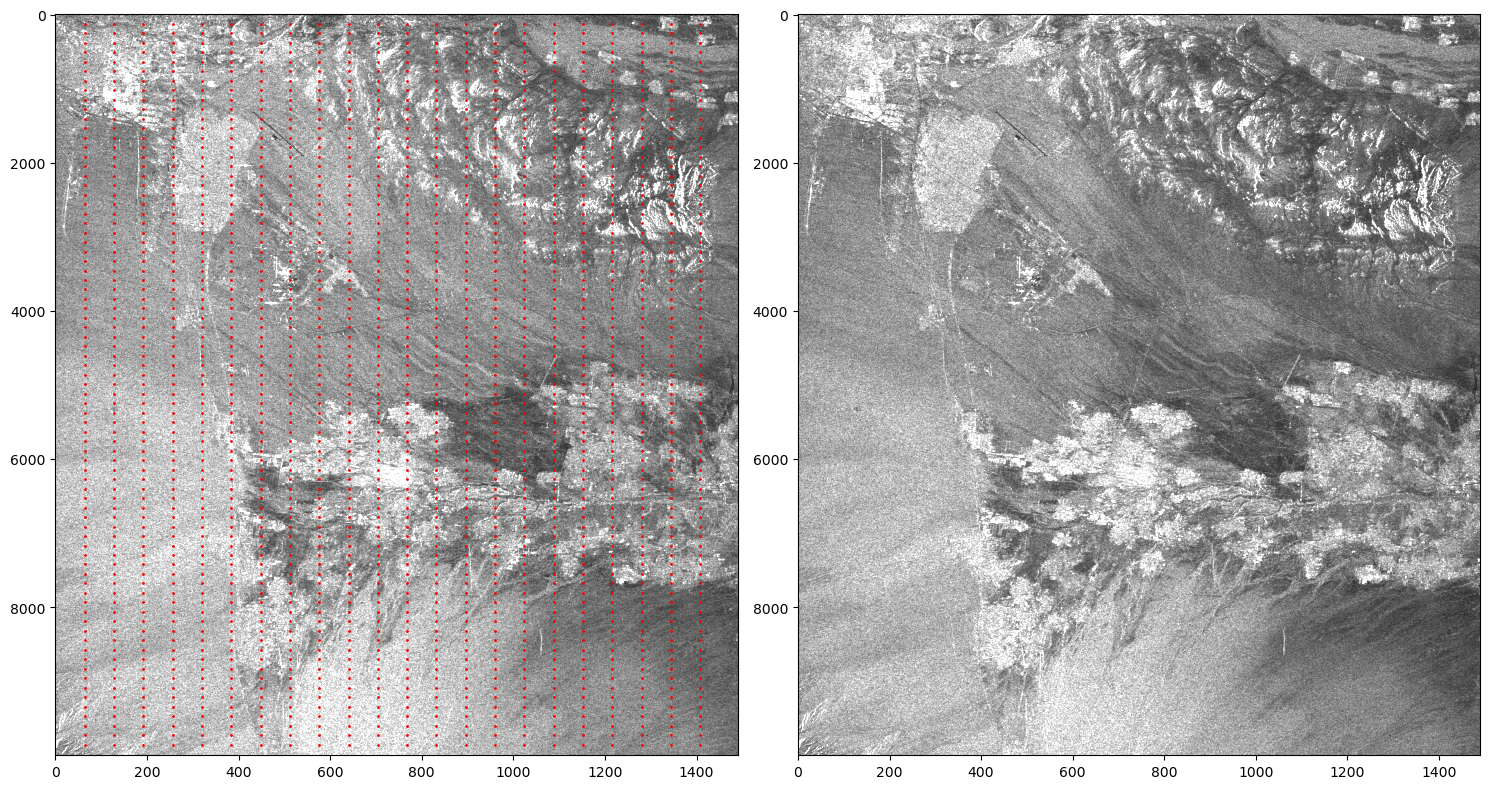

In [28]:
fig = plt.figure(figsize=(15, 8))

# display amplitude of the slc
fr1 = fig.add_subplot(1,2,1)

fr1.imshow(reference_raster_amp_sliced, vmin=None, vmax=4, cmap='gray', aspect='auto')

fr1.scatter(xs, ys, color='red', s=1)

# for i in range(len(xs)):
#     if i == 800:
#         color="red"
#     else:
#         color="black"
    
#     fr1.plot([xs[i] - WindowX, xs[i] + WindowX, xs[i] + WindowX, xs[i] - WindowX,  xs[i] - WindowX], [ys[i] - WindowY, ys[i] - WindowY, ys[i] + WindowY, ys[i] + WindowY, ys[i] - WindowY],
#              color=color, linewidth=1)

fr2 = fig.add_subplot(1,2,2)

fr2.imshow(secondary_coreg_raster_amp_sliced, vmin=None, vmax=4, cmap='gray', aspect='auto')

fig.tight_layout()

plt.show()

In [29]:
### Get search window

windowindex = 800

### Slice

def generate_window(input_raster, central_pixelY, centralpixelX, windowY, windowX):
    window_offsetY, window_offsetX = int((windowY - 1) / 2), int((windowX - 1) / 2)

    return input_raster[
        central_pixelY - window_offsetY : central_pixelY + window_offsetY,
        centralpixelX - window_offsetX : centralpixelX + window_offsetX,
    ]

reference_search_window = generate_window(reference_raster_amp_sliced, ys[windowindex], xs[windowindex], WindowY, WindowX)
reference_search_window_despeck = generate_window(reference_raster_amp_sliced_despeck, ys[windowindex], xs[windowindex], WindowY, WindowX)

secondary_search_window = generate_window(secondary_coreg_raster_amp_sliced, ys[windowindex], xs[windowindex], WindowY, WindowX)
secondary_search_window_despeck = generate_window(secondary_coreg_raster_amp_sliced_despeck, ys[windowindex], xs[windowindex], WindowY, WindowX)


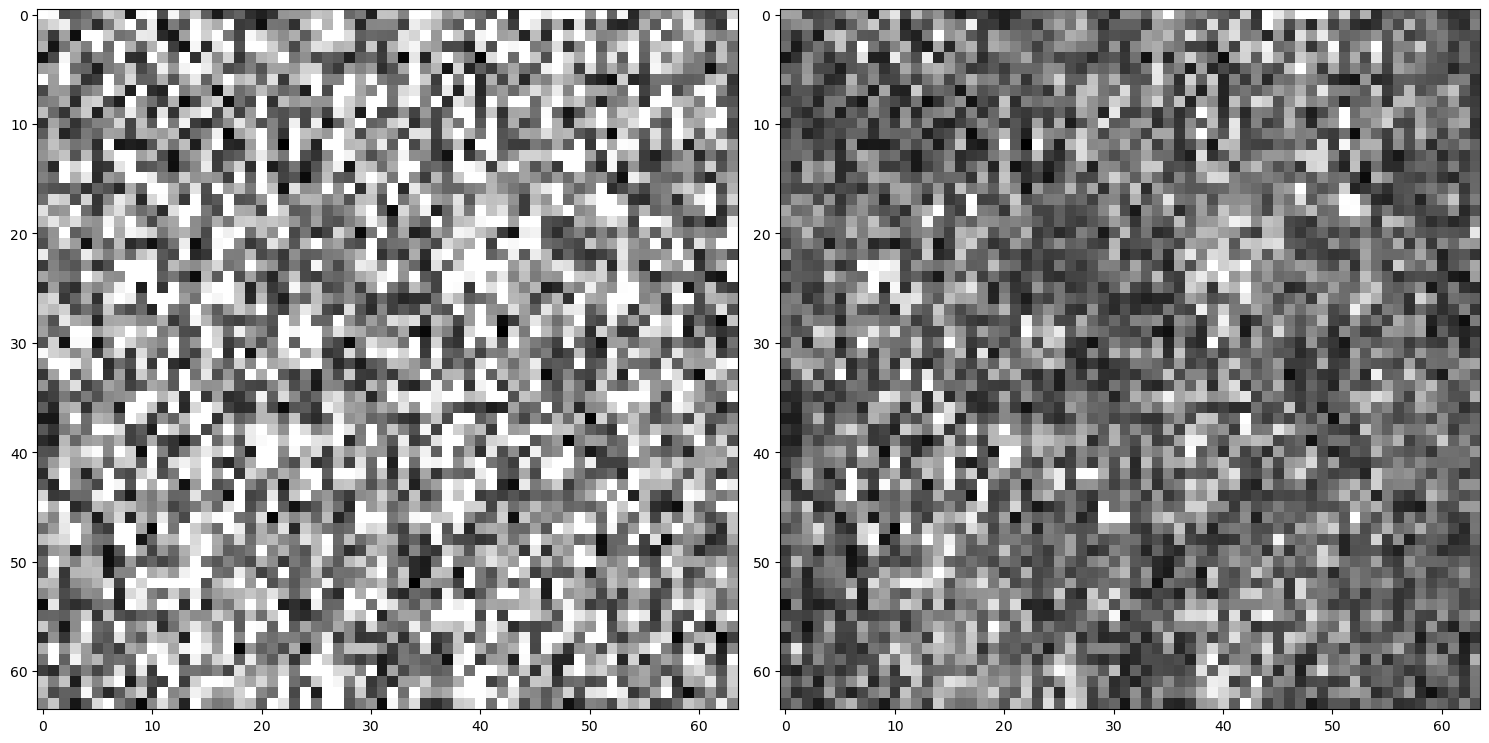

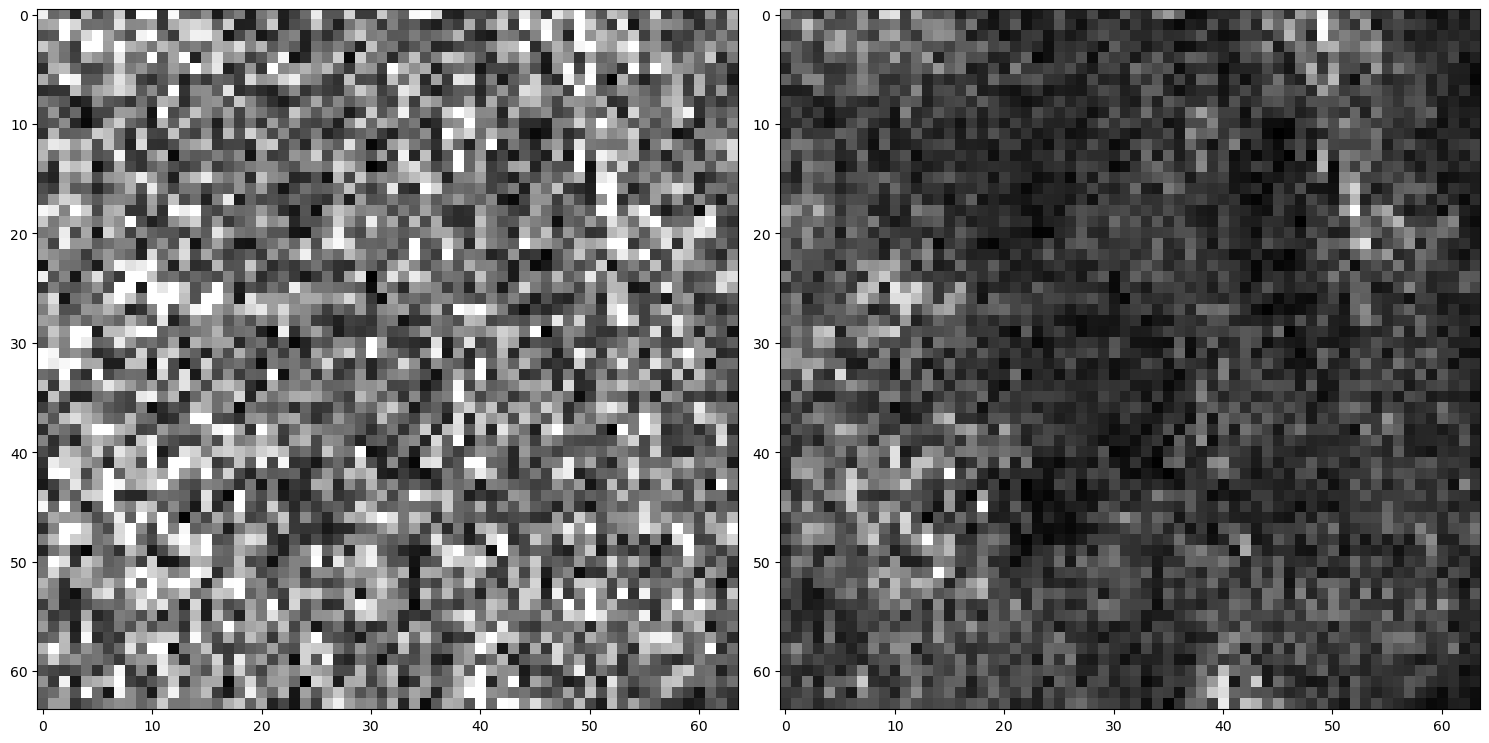

In [30]:
fig = plt.figure(figsize=(15, 8))


fr1 = fig.add_subplot(1,2,1)

fr1.imshow(reference_search_window, vmin=None, vmax=4, cmap='gray')

fr2 = fig.add_subplot(1,2,2)

fr2.imshow(reference_search_window_despeck, vmin=None, vmax=4, cmap='gray')


fig.tight_layout()

plt.show()


fig = plt.figure(figsize=(15, 8))


fr1 = fig.add_subplot(1,2,1)

fr1.imshow(secondary_search_window, vmin=None, vmax=4, cmap='gray')

fr2 = fig.add_subplot(1,2,2)

fr2.imshow(secondary_search_window_despeck, vmin=None, vmax=4, cmap='gray')


fig.tight_layout()

plt.show()

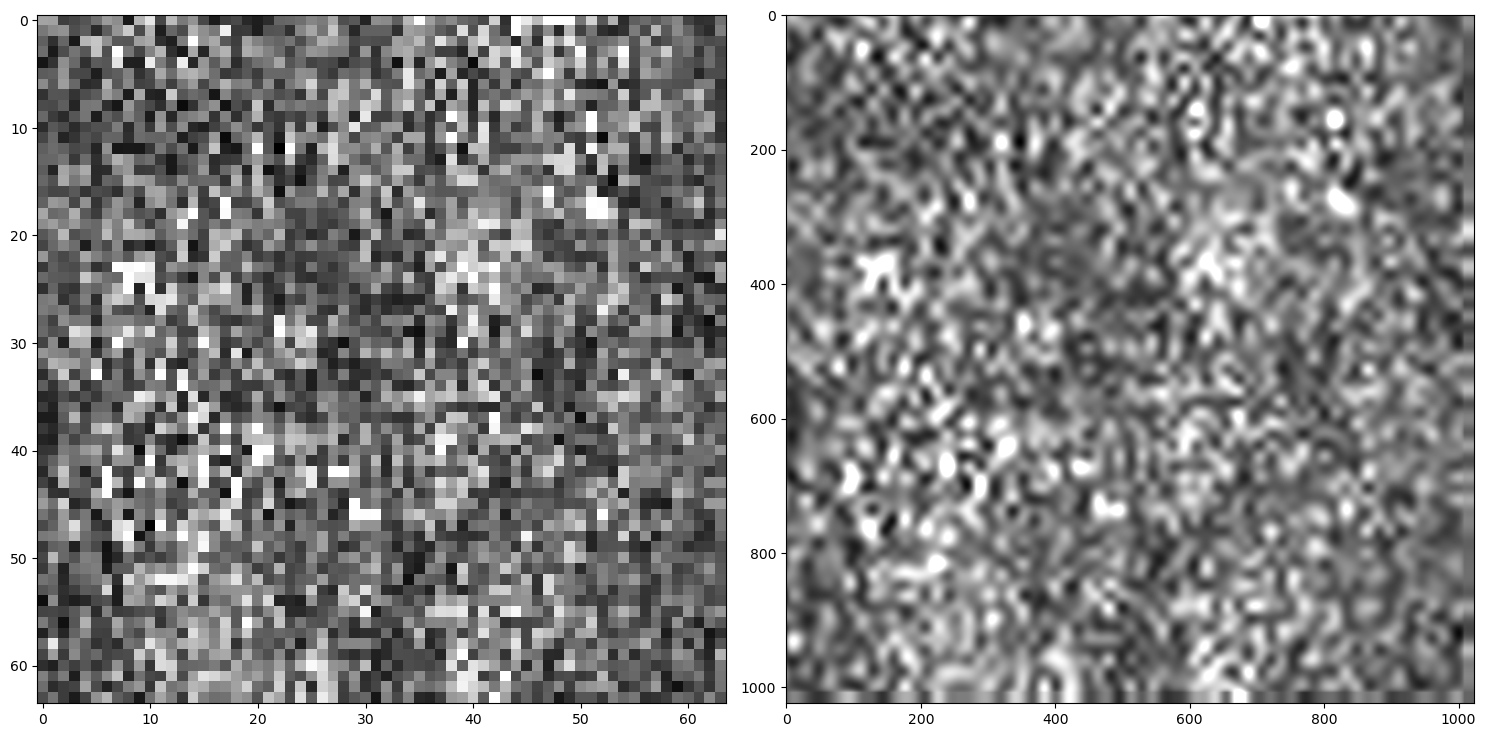

In [31]:
from scipy.interpolate import RectBivariateSpline

def interpolateCubic(image, scaling):
    rbs = RectBivariateSpline(range(image.shape[0]), range(image.shape[1]), image)

    interpvals = np.arange(0, image.shape[0], scaling)

    return rbs(interpvals, interpvals)


fig = plt.figure(figsize=(15, 8))


fr1 = fig.add_subplot(1,2,1)

fr1.imshow(reference_search_window_despeck, vmin=None, vmax=4, cmap='gray')

fr2 = fig.add_subplot(1,2,2)

fr2.imshow(interpolateCubic(reference_search_window_despeck, 1/16), vmin=None, vmax=4, cmap='gray')


fig.tight_layout()

plt.show()



In [32]:
def NCC(reference, secondary):
    """Taking the input rasters to calculate a single NCC value, see Cai et al. 2007"""
    normalized_reference = reference - np.mean(reference)
    normalized_secondary = secondary - np.mean(secondary)

    numerator = np.abs(np.sum(np.multiply(normalized_reference, normalized_secondary)))

    denominator = np.sqrt(np.sum(np.power(normalized_reference, 2))) * np.sqrt(
        np.sum(np.power(normalized_secondary, 2))
    )

    return numerator / denominator

def interpolatedNCC(reference, secondary):
    """Taking the input rasters to calculate a single NCC value, see Cai et al. 2007"""
    
    reference = interpolateCubic(reference, 1/16)
    secondary = interpolateCubic(secondary, 1/16)
    
    normalized_reference = reference - np.mean(reference)
    normalized_secondary = secondary - np.mean(secondary)

    numerator = np.abs(np.sum(np.multiply(normalized_reference, normalized_secondary)))

    denominator = np.sqrt(np.sum(np.power(normalized_reference, 2))) * np.sqrt(
        np.sum(np.power(normalized_secondary, 2))
    )

    return numerator / denominator

In [33]:
starttime = time.time()

search_radius = 24

central_pixel = (ys[windowindex], xs[windowindex])

reference_window = generate_window(
    reference_raster_amp_sliced, central_pixel[0], central_pixel[1], WindowY, WindowX
)

relative_index = np.mgrid[
    -search_radius : search_radius + 1, -search_radius : search_radius + 1
]

pixelY = relative_index[0] + central_pixel[0]

pixelX = relative_index[1] + central_pixel[1]

Cvals = np.zeros_like(pixelY, dtype=float)

maxi, maxj = Cvals.shape

for i in range(maxi):
    for j in range(maxj):
        Cvals[i, j] = NCC(
            reference_window,
            generate_window(
                secondary_coreg_raster_amp_sliced,
                pixelY[i, j],
                pixelX[i, j],
                WindowY,
                WindowX,
            ),
        )


print(NCC(reference_window, secondary_search_window))

endtime = time.time()

print(str(endtime - starttime) + " seconds")

0.4114167
0.24181532859802246 seconds


In [34]:
starttime = time.time()

search_radius = 8

central_pixel = (ys[windowindex], xs[windowindex])

reference_window = generate_window(
    reference_raster_amp_sliced, central_pixel[0], central_pixel[1], WindowY, WindowX
)
relative_index = np.mgrid[
    -search_radius : search_radius + 1, -search_radius : search_radius + 1
]

pixelY = relative_index[0] + central_pixel[0]

pixelX = relative_index[1] + central_pixel[1]

Cvals = np.zeros_like(pixelY, dtype=float)

maxi, maxj = Cvals.shape

for i in range(maxi):
    for j in range(maxj):
        Cvals[i, j] = NCC(
            reference_window,
            generate_window(
                secondary_coreg_raster_amp_sliced,
                pixelY[i, j],
                pixelX[i, j],
                WindowY,
                WindowX,
            ),
        )


print(NCC(reference_window, secondary_search_window))

endtime = time.time()

print(str(endtime - starttime) + " seconds")

0.4114167
0.03320574760437012 seconds


0.1827387809753418 seconds


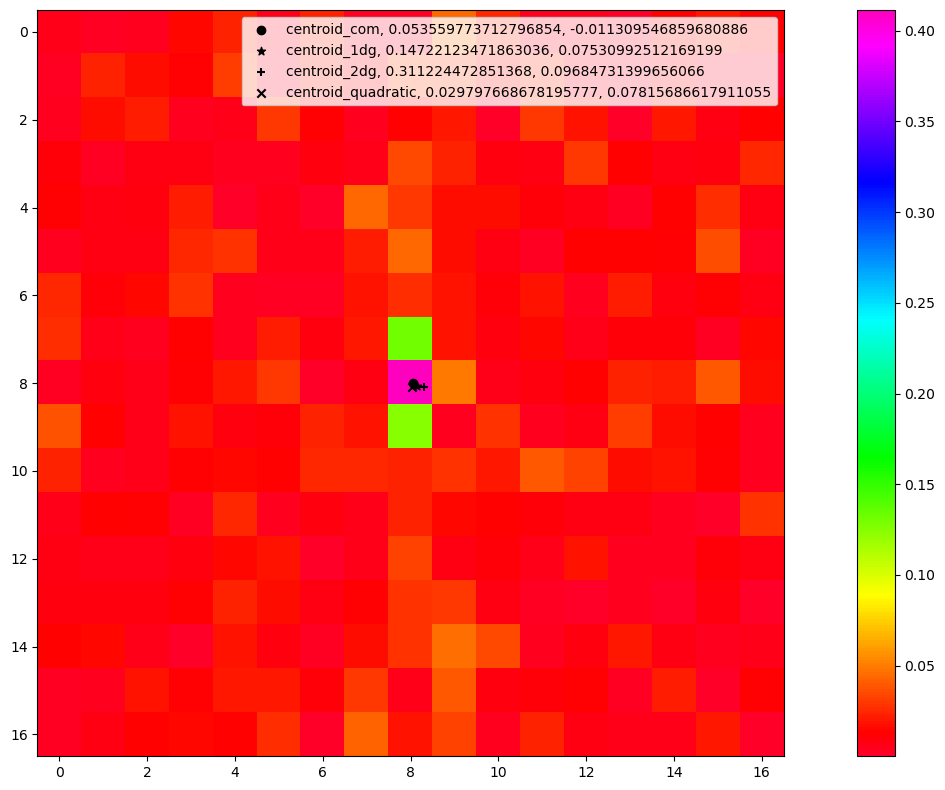

In [35]:
from photutils.centroids import (centroid_1dg, centroid_2dg,
                                 centroid_com, centroid_quadratic)

starttime = time.time()

x_com, y_com = centroid_com(Cvals)

x_1dg, y_1dg = centroid_1dg(Cvals)

x_2dg, y_2dg = centroid_2dg(Cvals)

x_quad, y_quad = centroid_quadratic(Cvals)

endtime = time.time()

print(str(endtime - starttime) + " seconds")

fig = plt.figure(figsize=(15, 8))

fr1 = fig.add_subplot(1,1,1)

image = fr1.imshow(Cvals, vmin=None, vmax=None, cmap='gist_rainbow')

fr1.scatter(x_com, y_com, color="black", marker='o', label=f"centroid_com, {x_com - search_radius}, {y_com - search_radius}")

fr1.scatter(x_1dg, y_1dg, color="black", marker='*', label=f"centroid_1dg, {x_1dg- search_radius}, {y_1dg- search_radius}")

fr1.scatter(x_2dg, y_2dg , color="black", marker='+', label=f"centroid_2dg, {x_2dg- search_radius}, {y_2dg- search_radius}")

fr1.scatter(x_quad, y_quad, color="black", marker='x', label=f"centroid_quadratic, {x_quad- search_radius}, {y_quad- search_radius}")

fig.colorbar(image, ax=fr1)

fr1.legend()

fig.tight_layout()

plt.show()


### Ideas

* use circular correlation window (masking outside of radius)
* use intensity interpolation
* how to assess error in range vs. azimuth
* Assess various fitting algorithms
* multilook initial images

In [36]:
def subpixel_peak(array, maximum_index : type(list)):
    y, x = maximum_index
    
    bminmin     = array[y - 1, x - 1]
    bstarmin    = array[y, x - 1]
    bplusmin    = array[y + 1, x - 1]
    bminstar    = array[y - 1, x]
    bstarstar   = array[y, x]
    bplusstar   = array[y + 1, x]
    bminplus    = array[y - 1, x + 1]
    bstarplus   = array[y, x + 1]
    bplusplus   = array[y + 1, x + 1]
    
    A   = (bminmin - 2 * bstarmin + bplusmin + bminstar - 2 * bstarstar + bplusstar + bminplus - 2 * bstarplus + bplusplus)/6
    B   = (bminmin - bplusmin - bminplus + bplusplus)/4
    C   = (bminmin + bstarmin + bplusmin - 2 * bminstar - 2 * bstarstar - 2 * bplusstar + bminplus + bstarplus + bplusplus)/6
    D   = (-bminmin + bplusmin - bminstar + bstarplus - bminplus + bplusplus)/6
    E   = (-bminmin - bstarmin - bplusmin + bminplus + bstarplus + bplusplus)/6
    # F   = (-bminmin + 2 * bstarmin - bplusmin + 2 * bminstar + 5 * bstarstar + 2 * bplusstar - bminplus + 2 * bstarplus - bplusplus)/9
    
    x   = (B * E - 2 * C * D)/(4 * A * C - B * B)
    y   = (B * D - 2 * A * E)/(4 * A * C - B * B)
    
    return (y, x)

In [37]:
y, x = subpixel_peak(Cvals, (25, 25))

IndexError: index 24 is out of bounds for axis 0 with size 17

In [ ]:
print(y,x)

-2.524947796888635 5.037753345237597


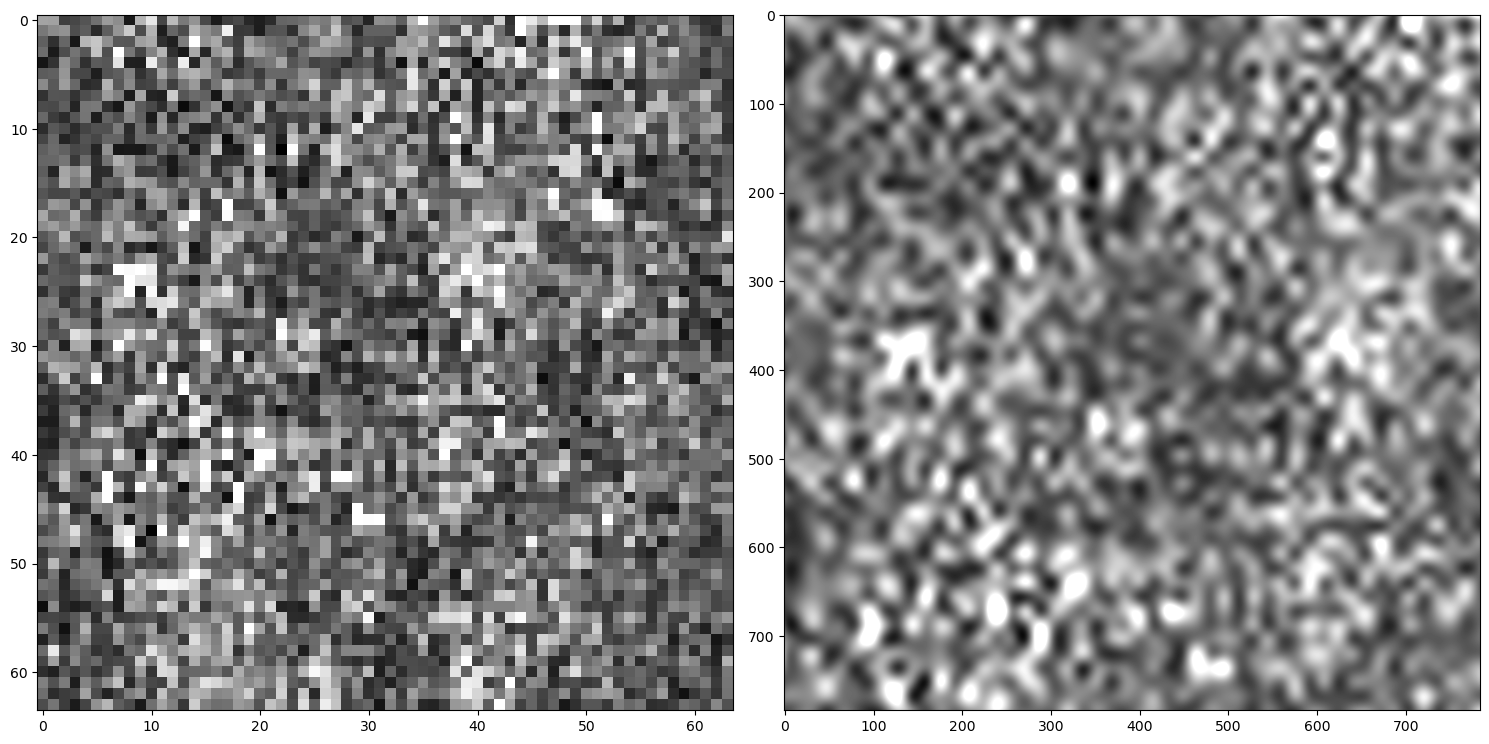

In [ ]:
image = reference_search_window_despeck


fig = plt.figure(figsize=(15, 8))


fr1 = fig.add_subplot(1,2,1)

fr1.imshow(image, vmin=None, vmax=4, cmap='gray')

fr2 = fig.add_subplot(1,2,2)

interpvals = np.arange(0, 49, 1/16)

rbs = RectBivariateSpline(range(image.shape[0]), range(image.shape[1]), image)

fr2.imshow(rbs(interpvals, interpvals), vmin=None, vmax=4, cmap='gray')


fig.tight_layout()

plt.show()

In [ ]:
# functions

def NCC(reference, secondary):
    """Taking the input rasters to calculate a single NCC value, see Cai et al. 2007"""
    normalized_reference = reference - np.mean(reference)
    normalized_secondary = secondary - np.mean(secondary)

    numerator = np.abs(np.sum(np.multiply(normalized_reference, normalized_secondary)))

    denominator = np.sqrt(np.sum(np.power(normalized_reference, 2))) * np.sqrt(
        np.sum(np.power(normalized_secondary, 2))
    )

    return numerator / denominator

def generate_window(input_raster, central_pixelY, centralpixelX, windowY, windowX):
    window_offsetY, window_offsetX = int((windowY - 1) / 2), int((windowX - 1) / 2)

    return input_raster[
        central_pixelY - window_offsetY : central_pixelY + window_offsetY,
        centralpixelX - window_offsetX : centralpixelX + window_offsetX,
    ]

# params


@jit()
def runNCC():
    search_radius = 8
    
    NCCvals = []
    
    iteration=1
    iternum = len(xs)
    
    for point in range(len(xs)):

        central_pixel = (ys[point], xs[point])
        
        print(f"Iteration number: {iteration}/{iternum}: {iteration/iternum*100}%", central_pixel)

        reference_window = generate_window(
            reference_raster_amp_sliced, central_pixel[0], central_pixel[1], WindowY, WindowX
        )

        relative_index = np.mgrid[
            -search_radius : search_radius + 1, -search_radius : search_radius + 1
        ]

        pixelY = relative_index[0] + central_pixel[0]

        pixelX = relative_index[1] + central_pixel[1]

        Cvals = np.zeros_like(pixelY, dtype=float)

        maxi, maxj = Cvals.shape

        for i in range(maxi):
            for j in range(maxj):
                Cvals[i, j] = NCC(
                    reference_window,
                    generate_window(
                        secondary_coreg_raster_amp_sliced,
                        pixelY[i, j],
                        pixelX[i, j],
                        WindowY,
                        WindowX,
                    ),
                )
                
        x_quad, y_quad = centroid_quadratic(Cvals) - search_radius
        
        if np.abs(x_quad) > 1:
            print(x_quad, y_quad)
            x_quad, y_quad = np.nan, np.nan
        elif np.abs(y_quad) > 1:
            print(x_quad, y_quad)
            x_quad, y_quad = np.nan, np.nan

        NCCvals.append({
            "pixelcoords_y": central_pixel[0], "pixelcoords_x": central_pixel[1],
            "pixeltracking_y": y_quad, "pixeltracking_x": x_quad}
            )
        
        iteration+=1
        
    return NCCvals
        
NCCvals = runNCC()



/tmp/ipykernel_5422/2438269795.py:27: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @jit()
/tmp/ipykernel_5422/2438269795.py:27: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "runNCC" failed type inference due to: Untyped global name 'generate_window': Cannot determine Numba type of <class 'function'>

File "../../../tmp/ipykernel_5422/2438269795.py", line 42:
<source missing, REPL/exec in use?>

  @jit()
/tmp/ipykernel_5422/2438269795.py:27: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "runNCC" failed type inference due to: Cannot determine Numba type of <class '

/home/yad2/.conda/envs/PixelTracking/lib/python3.10/site-packages/numba/core/object_mode_passes.py:151: NumbaWarning: Function "runNCC" was compiled in object mode without forceobj=True.

File "../../../tmp/ipykernel_5422/2438269795.py", line 36:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaWarning(warn_msg,
/home/yad2/.conda/envs/PixelTracking/lib/python3.10/site-packages/numba/core/object_mode_passes.py:161: NumbaDeprecationWarning: 
Fall-back from the nopython compilation path to the object mode compilation path has been detected. This is deprecated behaviour that will be removed in Numba 0.59.0.

For more information visit https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit

File "../../../tmp/ipykernel_5422/2438269795.py", line 36:
<source missing, REPL/exec in use?>

  warnings.warn(errors.NumbaDeprecationWarning(msg,


In [ ]:
import pandas as pd 

df = pd.DataFrame.from_dict(NCCvals)

df

pixelcoords_y  pixelcoords_x  pixeltracking_y  pixeltracking_x
0               128             64         0.268689         0.189212
1               256             64        -0.084487        -0.081846
2               384             64        -0.177356        -0.221110
3               512             64        -1.113245         0.134730
4               640             64         0.053957        -0.074468
...             ...            ...              ...              ...
1689           9344           1408        -0.011590        -0.007148
1690           9472           1408         0.009775         0.017365
1691           9600           1408        -0.017014        -0.017249
1692           9728           1408        -0.021381        -0.066676
1693           9856           1408         0.044129         0.006386

[1694 rows x 4 columns]

6.351069947522786


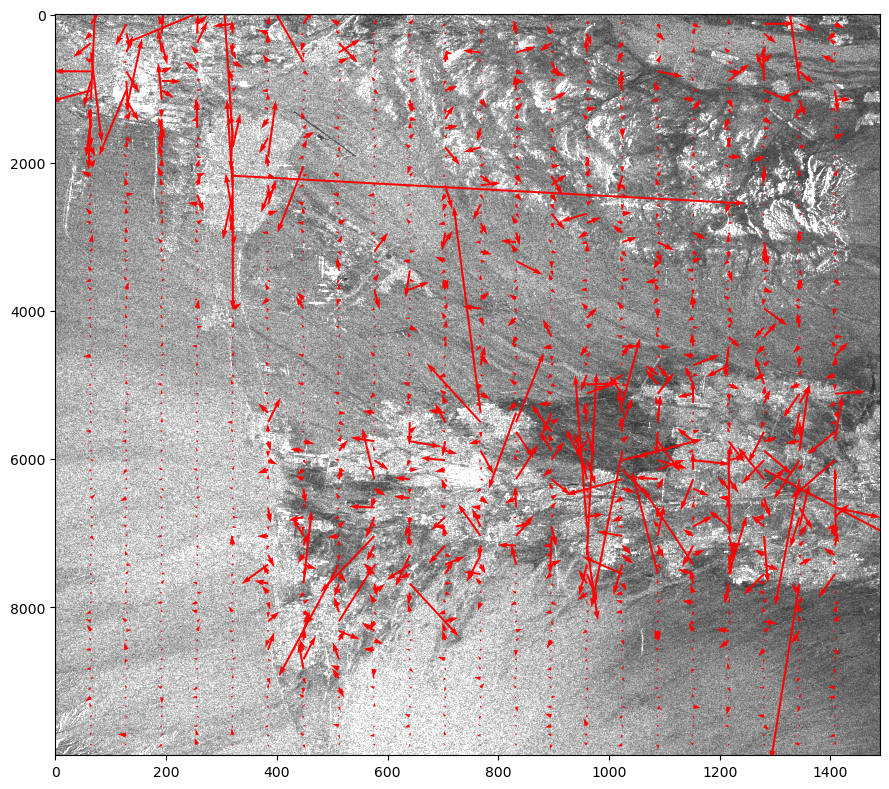

In [ ]:
fig = plt.figure(figsize=(9, 8))

# display amplitude of the slc
fr1 = fig.add_subplot(1,1,1)

fr1.imshow(reference_raster_amp_sliced, vmin=None, vmax=4, cmap='gray', aspect='auto')

fr1.quiver(df["pixelcoords_x"], df["pixelcoords_y"], df["pixeltracking_x"], df["pixeltracking_y"], color='red')

print(np.nanmax(df["pixeltracking_x"].values))

# for i in range(len(xs)):
#     if i == 800:
#         color="red"
#     else:
#         color="black"
    
#     fr1.plot([xs[i] - WindowX, xs[i] + WindowX, xs[i] + WindowX, xs[i] - WindowX,  xs[i] - WindowX], [ys[i] - WindowY, ys[i] - WindowY, ys[i] + WindowY, ys[i] + WindowY, ys[i] - WindowY],
#              color=color, linewidth=1)

fig.tight_layout()

plt.show()